# 📘 WIP: (Title)

This tutorial demonstrates (Title) using the ORCA python interfacte (OPI).

In this notebook we will:
1.  Import the required Python dependencies
2.  Define a working directory
3.  Prepare and visualize input structures
4.  Run ORCA calculations with COSMO solvation
5.  Parse .orcacosmo output files and extract sigma profiles
6.  Compute solubility using openCOSMO-RS (non-iterative and iterative methods)

## Step 1: Import Dependencies

We start by importing the modules needed for:
- Interfacing with ORCA input/output
- Plotting results
- Numerical calculations and data handling
- Handling for directory
- Performing COSMO-RS calculations using the openCOSMO-RS library

In [8]:
# > Import pathlib for directory handling
from pathlib import Path

# > Import necessary libraries for numerical computations
import numpy as np
from scipy.optimize import fsolve

# > Import the openCOSMO-RS library components
from opencosmorspy.parameterization import openCOSMORS24a
from opencosmorspy.cosmors import COSMORS
from opencosmorspy.input_parsers import SigmaProfileParser

# > OPI imports for performing ORCA calculations and reading output
from opi.core import Calculator
from opi.input.structures.structure import Structure
from opi.input.simple_keywords import SolvationModel, Solvent

# > Import libraries for visualization
from matplotlib import pyplot as plt
import py3Dmol

## Step 2: Define Working directory

All actual calculations will be performed in a subfolder **RUN**.

In [9]:
# > Create a working directory for calculations if it doesn't already exist
working_dir = Path("RUN")
working_dir.mkdir(exist_ok=True)

## Step 3: Prepare and Visualize Input Structures

We use **water** as our example molecule. The 3D structure in Cartesian coordinates is defined in XYZ format and visualized.

In [10]:
# > define cartesian coordinates in Angstroem as python string 
xyz_data = """\
3

  O  -0.0007948665470900  0.4014278382603300  0.0000000000000000
  H  -0.7647999815056600  -0.2022173883142000  0.0000000000000000
  H  0.7655948480527500  -0.1992104499461300  0.0000000000000000\n
"""
# > Visualize the input structure
view = py3Dmol.view(width=400, height=400)
view.addModel(xyz_data, 'xyz')
view.setStyle({}, {'stick': {'radius': 0.1}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.show()

# > Write the input structure to a file for reading
with open(working_dir / "struc.xyz","w") as f:
    f.write(xyz_data)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 4: Calculation with COSMO solvation

We run a caculation using the **COSMO solvation model** with ethanol as the solvent.

In [11]:
# > Set up path and create directory
xyz_file = Path("./RUN/struc.xyz")

# > Create a Calculator object for ORCA input generation and execution
calc = Calculator(basename="cosmors", working_dir=working_dir)

# > Load the molecular structure from XYZ file
structure = Structure.from_xyz(working_dir / "struc.xyz")
calc.structure = structure
calc.structure.charge = 0
calc.structure.multiplicity = 1

calc.input.add_arbitrary_string("!COSMORS(ethanol)")

# write the ORCA input file
calc.write_input()
# run the ORCA calculation
print("Running ORCA calculation with COSMO solvation...", end="")
calc.run()
print("   Done")

Running ORCA calculation with COSMO solvation...   Done


## Step 5: Analyze COSMO Output and Sigma Profiles

After the ORCA COSMO-RS calculation completes, we parse the resulting .orcacosmo files to:

- Visualize the sigma profile (σ-profile)

- Extract molecular descriptors such as dipole moment, surface area, volume, and hydrogen-bonding moments

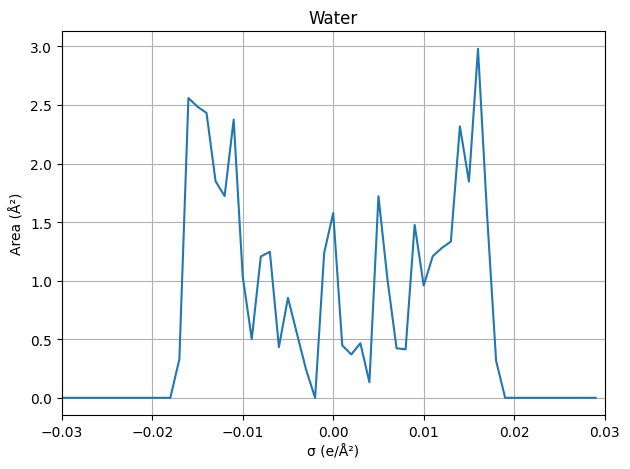

sigma_moments: [4.28977468e+01 7.90903554e-05 6.05283055e+01 3.89164821e+00
 1.20345287e+02 1.77937287e+01 2.66092559e+02]
hb_donor_moment: [5.11873012 2.60564439 0.85940158]
hb_acceptor_moment: [5.76486365 3.31610676 1.37737025]
energy_dielectric: -32.83919025918012
dipole_moment: None
area_total: 42.897746777517476
volume: 25.36550524969701


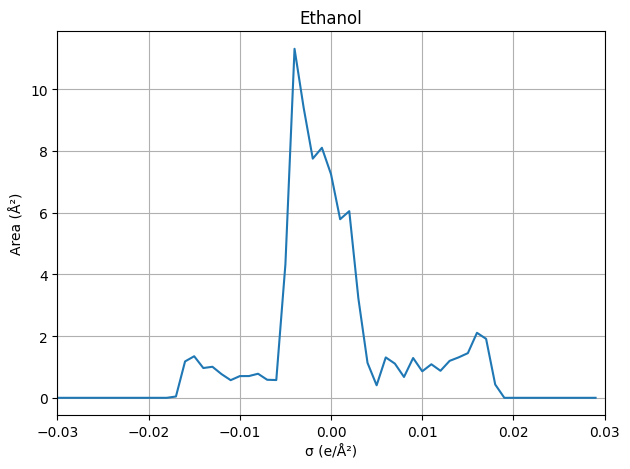

sigma_moments: [ 8.95401962e+01 -3.52247325e-04  4.47559164e+01  1.76051131e+01
  8.17805643e+01  4.88191312e+01  1.85692127e+02]
hb_donor_moment: [2.30899094 1.1905562  0.38328986]
hb_acceptor_moment: [4.83674399 2.87227988 1.31135965]
energy_dielectric: -25.107211968398246
dipole_moment: None
area_total: 89.54019619110814
volume: 68.36643463429641


In [12]:
def process_molecule(file_path: Path, name: str) -> None:
    """Process .orcacosmo file to visualize sigma profile and extract descriptors"""
    spp = SigmaProfileParser(file_path)
    
    # > Generate sigma profile
    sigmas, areas = spp.cluster_and_create_sigma_profile()
    
    plt.figure()
    plt.title(name)
    plt.plot(sigmas, areas)
    plt.xlim([-0.03, 0.03])
    plt.xlabel("σ (e/Å²)")
    plt.ylabel("Area (Å²)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # > Calculate descriptors
    spp.calculate_sigma_moments()
    descriptors = {
        'sigma_moments': spp['sigma_moments'],
        'hb_donor_moment': spp['sigma_hydrogen_bond_donor_moments'][2:5],
        'hb_acceptor_moment': spp['sigma_hydrogen_bond_acceptor_moments'][2:5],
        'energy_dielectric': spp['energy_dielectric'],
        'dipole_moment': spp['dipole_moment'],
        'area_total': spp['area'],
        'volume': spp['volume']
    }
    for key, value in descriptors.items():
        print(f"{key}: {value}")

# > Define paths to .orcacosmo files for the solute and solvent
cosmo_files = {
    'Water': './RUN/cosmors.solute.orcacosmo',
    'Ethanol': './RUN/cosmors.solvent.orcacosmo'
}

# > Loop through and process both solute and solvent
for custom_name, file_path in cosmo_files.items():
    process_molecule(file_path, name=custom_name)

## Step 6: Predict Solubility Using openCOSMO-RS

We use the openCOSMO-RS to calculate the activity coefficient (ln(γ)) and predict solubility using both:

- A non-iterative method

- An iterative method that solves the full equilibrium condition

The results are printed and compared.

In [13]:
R = 8.314 # > Gas constant J/(mol·K)
DELTA_H_FUSION = 27.1e3 # > Fusion enthalpy of the solute (J/mol)
T_FUSION = 443.6 # > Fusion temperature of the solute (K)
TEMP = 298.15 # > Temperature for the solubility calculation (K)

def compute_ln_gamma(crs: COSMORS, mole_fractions: list[float], temp: float) -> float:
    """Compute ln(gamma) for a given composition at specified temperature using openCOSMO-RS"""
    crs.clear_jobs()
    crs.add_job(np.array(mole_fractions), temp, refst='pure_component')
    return crs.calculate()['tot']['lng'][0][0]

def solubility(crs: COSMORS, delta_h_fus: float, t_fus: float, temp: float, iterative: bool) -> float:
    """Estimate solubility from openCOSMO-RS ln(gamma)"""
    rhs = -delta_h_fus / R * (1 / temp - 1 / t_fus)

    if not iterative:
        ln_gamma_inf = compute_ln_gamma(crs, [0.0, 1.0], temp)
        return np.exp(rhs - ln_gamma_inf)
    
    def equation(x_guess: float) -> float:
        """Equilibrium condition to be solved"""
        x_guess = max(1e-15, x_guess)
        x_guess = min(1, x_guess)
        x = np.array([x_guess, 1 - x_guess])
        ln_gamma = compute_ln_gamma(crs, x, temp)
        return np.abs(ln_gamma + np.log(x_guess) - rhs)

    result = fsolve(equation, 1e-5)
    
    x_sol = max(1e-15, result[0])
    x_sol = min(1, x_sol)
    return x_sol

def run_solubility_analysis(crs: COSMORS, solute_path: str, solvent_paths: list[str], solute_label: str, solvent_labels: list[str]) -> None:
    """Run solubility analysis comparing non-iterative and iterative results for given solute/solvents."""
    if solvent_labels is None:
        solvent_labels = [Path(p).stem for p in solvent_paths]

    print("Solubility Results:\n")
    print(f"Solute: {solute_label}\n")
    print(f"{'Solvent':<20} {'Non-Iterative':>15} {'Iterative':>15}")

    for solvent_path, solvent_name in zip(solvent_paths, solvent_labels):
        crs.clear_molecules()
        crs.add_molecule([solute_path])
        crs.add_molecule([solvent_path])

        x_non_iter = solubility(crs, DELTA_H_FUSION, T_FUSION, TEMP, iterative=False)
        x_iter = solubility(crs, DELTA_H_FUSION, T_FUSION, TEMP, iterative=True)

        print(f"{solvent_name:<20} {x_non_iter:>15.5e} {x_iter:>15.5e}")


# > Set up openCOSMO-RS with the 2024a parameterization
crs = COSMORS(par=openCOSMORS24a())

# > Define file paths and labels
solute_file = './RUN/cosmors.solute.orcacosmo'
solvent_files = ['./RUN/cosmors.solvent.orcacosmo']
solute_label = "Water"
solvent_labels = ["Ethanol"]

# > Run solubility analysis
run_solubility_analysis(crs, solute_file, solvent_files, solute_label=solute_label, solvent_labels=solvent_labels)

Solubility Results:

Solute: Water

Solvent                Non-Iterative       Iterative


Ethanol                  1.22223e-02     1.65567e-02
